# Import packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import os
import plotly.express as px
from fink_utils.photometry.conversion import dc_mag
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from datetime import datetime
from scipy.optimize import curve_fit
import copy
from gatspy import periodic
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import datetime

# Import data and keep only the more important features

In [7]:
liste = [
    'EB*', 'Mira', 'SN candidate', 'QSO', 'BLLac', 'Blazar',
    'Ambiguous','RRLyr', 'YSO', 'LPV*', 'AGN','Seyfert_1', 'AGN_Candidate', 'TTau*', 'Kilonova candidate'
] 
#deleted 'Early SN Ia candidate', 'Microlensing candidate'

#define df as an empty dataframe
df = pd.DataFrame()

dossier = '/home/centos/data/data_march'
name = {}
count = 0
for nom_fichier in liste:
    chemin = os.path.join(dossier, "finkclass=" + nom_fichier)

    temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(min(10, len(os.listdir(chemin))))])

    #add a column with the name of the file
    name[nom_fichier.split('=')[-1]] = count
    count += 1
    
    #concatenate the dataframes
    df = pd.concat([df, temp], ignore_index=True)

kilonova = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Kilonova candidate')
ambiguous = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Ambiguous')
SN = pd.read_parquet('/home/centos/data/balanced_data/finkclass=SN candidate')

#Add a column 'finkclass' with the value Kilonova candidate
kilonova['finkclass'] = 'Kilonova candidate'
ambiguous['finkclass'] = 'Ambiguous'
SN['finkclass'] = 'SN candidate'
df = pd.concat([df, kilonova, ambiguous, SN], ignore_index=True)


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


In [8]:
variable_star_class = ['EB*', 'Mira', 'RRLyr', 'YSO', 'LPV*', "TTau*"]
AGN_class = ['QSO', 'BLLac', 'Blazar', 'AGN', 'Seyfert_1', 'AGN_Candidate']

def define_meta_class(ele):
    if ele in variable_star_class:
        ele = "Variable Star"

    elif ele in AGN_class:
        ele = "AGN"

    return ele

#for every items in df change the value of the column 'finkclass' by applying the function define_meta_class
df['finkclass'] = df['finkclass'].apply(define_meta_class)


In [9]:
#take the first 500 elements of each class
df = df.groupby('finkclass').head(200)
df = df.reset_index(drop=True)
print(df['finkclass'].value_counts())


Variable Star         200
SN candidate          200
AGN                   200
Ambiguous             200
Kilonova candidate    186
Name: finkclass, dtype: int64


In [10]:
# extract columns of interest
cols = [
    'rf_kn_vs_nonkn',
    'rf_snia_vs_nonia',
    'snn_sn_vs_all',
    'snn_snia_vs_nonia'
]


cols_in_candidate = [
    'jdstarthist',
    'magpsf',
    'sigmapsf',
    'fid', 
    'magnr', 
    'sigmagnr', 
    'isdiffpos',
    'neargaia',
    'sgscore1',
    'classtar'
]


# Adding the alert ZTF23aaaatwl

In [11]:
import requests
import pandas as pd
import io
# get data for ZTF19acnjwgm
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF23aaaatwl',
        'withupperlim': True,
        'output-format': 'json'
    }
)
# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

temp = []

for col in cols:
    temp.append('d:' + col)

for col in cols_in_candidate:
    temp.append('i:' + col)

In [12]:
# moment de la detection d'anomalie
t0 = pdf[pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]['i:jd'].values[0]

# donnees 30 jours avant l'anomalie
pdf_anomalous = pdf[(pdf['i:jd'] >= t0 - 30) & (pdf['i:jd'] <= t0)]

In [13]:
from fink_science.ad_features.processor import extract_features_ad_raw

features = extract_features_ad_raw(
  pdf_anomalous['i:magpsf'], 
  pdf_anomalous['i:jd'], 
  pdf_anomalous['i:sigmapsf'], 
  pdf_anomalous['i:fid'], 
  pdf['i:objectId'].values[0]
)

In [14]:
to_add = pdf[pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])][temp]
#create a df with every element of the dictionnary located in df['lc_features_g']
green = pd.DataFrame([features[1]])

#create a df with every element of the dictionnary located in df['lc_features_g']
red = pd.DataFrame([features[2]])

#rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
green = green.add_suffix('_g')
red = red.add_suffix('_r')

to_add = to_add.reset_index(drop=True)

anomaly = pd.concat([to_add, green, red], axis=1)

In [15]:
#when a column start with a letter and then :, suppress the letter and the :
anomaly.columns = [col[2:] if col[1] == ':' else col for col in anomaly.columns]

## Colormaping

In [16]:
name_meta = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Ambiguous': 3,
 'Kilonova candidate': 4}

#create a list with len(name) different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(name_meta)))

#for every key in the dictionnary name, change name[key] by colors[ind]
for ind, key in enumerate(name_meta):
    name_meta[key] = colors[ind]

# Keep the most important features according to PCA

In [17]:
#extract columns of interest in df
df_filt = df[cols]

#create a df with the columns of interest in candidate which are located in df['candidate']
df_candidate = pd.DataFrame(df['candidate'].tolist(), columns=cols_in_candidate)

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_g = pd.DataFrame(df['lc_features_g'].tolist())

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_r = pd.DataFrame(df['lc_features_r'].tolist())

#rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
df_lc_features_g = df_lc_features_g.add_suffix('_g')
df_lc_features_r = df_lc_features_r.add_suffix('_r')

#concatenate the two dataframes
df_filt = pd.concat([df_filt, df_candidate, df_lc_features_g, df_lc_features_r], axis=1)

#in the column isdiffpos, replace t by 1 and f by -1
df_filt['isdiffpos'] = df_filt['isdiffpos'].replace({'t': 1, 'f': -1})
anomaly['isdiffpos'] = anomaly['isdiffpos'].replace({'t': 1, 'f': -1})
#Normalizing data
anomaly = (anomaly - df_filt.mean()) / df_filt.std()
df_filt = (df_filt - df_filt.mean()) / df_filt.std()

#replace None or NaN by 0
anomaly = anomaly.fillna(0)
df_filt = df_filt.fillna(0)

#do a pca and show variance explained
n_components = 20

pca = PCA(n_components=n_components)
pca.fit(df_filt)

#select the variable with the highest absolute value in the first principal component
max_ind = np.argmax(np.abs(pca.components_[0]))

#select variable with a high absolute value of at least half of the principal component with the highest absolute value
selected_variables = df_filt.columns[np.abs(pca.components_[0]) > np.abs(pca.components_[0][max_ind]/2)]

#create a new df with the selected variables
df_filt_selected = df_filt[selected_variables]
anomaly_filt_selected = anomaly[selected_variables]


label = df['finkclass']

In [18]:
#take a random sample of 100 elements in df_filt_selected and label
df_filt_selected_sample = df_filt_selected.sample(n=200)
label_sample = label[df_filt_selected_sample.index]

#create an other sample with 100 different elements of df_filt_selected and label
df_filt_selected_sample2 = df_filt_selected.drop(df_filt_selected_sample.index)
df_filt_selected_sample2 = df_filt_selected_sample2.sample(n=200)
label_sample2 = label[df_filt_selected_sample2.index]

In [19]:
#creating a X_train containing all pair of X_train
X_train = []
y_train = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_train.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_train.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

X_test = []
y_test = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_test.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_test.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

In [20]:
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length

trainset = dataset(X_train, y_train)
#DataLoader
trainloader = DataLoader(trainset, batch_size=16, shuffle=False)

testset = dataset(X_test, y_test)
#DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [21]:
#create a neural network that take a element of X_train with size (2, 22) and predict the labels with a fc layer with 22 neurons

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nb_variables = len(selected_variables)
        self.stack = nn.Sequential(nn.Linear(2*nb_variables, 4*nb_variables),
        nn.ReLU(),
        nn.Linear(4*nb_variables, 2*nb_variables),
        nn.ReLU(),
        nn.Linear(2*nb_variables, 1),
        nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 2*len(selected_variables))
        x = self.stack(x)

        return x

net = Net()

#print the archetecture of the neural network
print(net)

#print the number of parameters
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (stack): Sequential(
    (0): Linear(in_features=36, out_features=72, bias=True)
    (1): ReLU()
    (2): Linear(in_features=72, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
5329


In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred[:,0], y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0], y).item()
            pred = torch.tensor([1 if pred[i] > 0.5 else 0 for i in range(len(pred))])
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

In [23]:
# Hyperparameters
learning_rate = 0.001
epochs = 500
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

### LOADING A MODEL WITH 98.5% ACCURACY

In [24]:
checkpoint = torch.load('results/models/model.pt')
net.load_state_dict(checkpoint)
error = list(np.loadtxt('results/models/errors.csv', delimiter=','))


### TRAINING THE MODEL

In [25]:
#error = []

for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    # Use train_loop and test_loop functions
    train_loop(trainloader, net, loss_fn, optimizer)
    x = test_loop(testloader, net, loss_fn)
    error.append(x)
print("Done!")

Epoch 1-----------------
loss: 1.819714  [    0/19900]
loss: 0.765717  [16000/19900]
Test Error: 
 Accuracy: 87.2%, Avg loss: 1.882538
Epoch 2-----------------
loss: 0.448546  [    0/19900]
loss: 0.266067  [16000/19900]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.942811
Epoch 3-----------------
loss: 0.123103  [    0/19900]
loss: 0.291749  [16000/19900]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.514012
Epoch 4-----------------
loss: 0.132267  [    0/19900]
loss: 0.265675  [16000/19900]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.509294
Epoch 5-----------------
loss: 0.138562  [    0/19900]
loss: 0.237104  [16000/19900]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.449736
Epoch 6-----------------
loss: 0.122397  [    0/19900]
loss: 0.223812  [16000/19900]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.359873
Epoch 7-----------------
loss: 0.153784  [    0/19900]
loss: 0.121884  [16000/19900]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.274290
Epoch 8-----------------
loss: 0.144274  [    0/19900]


KeyboardInterrupt: 

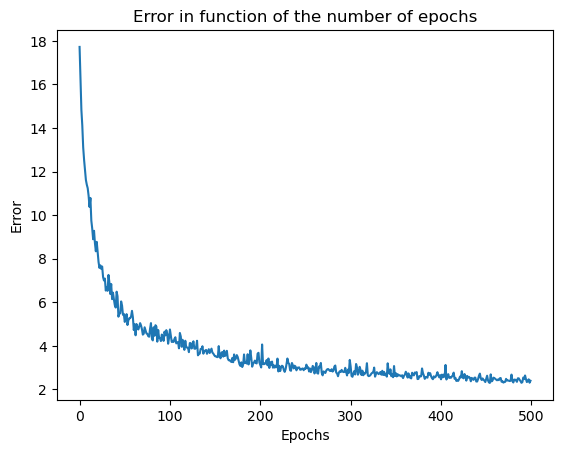

In [25]:
plt.plot(error)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error in function of the number of epochs')
#plt.ylim(0, 100)
plt.show()


# Graphs !

## Plot the graph !

/home/centos/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


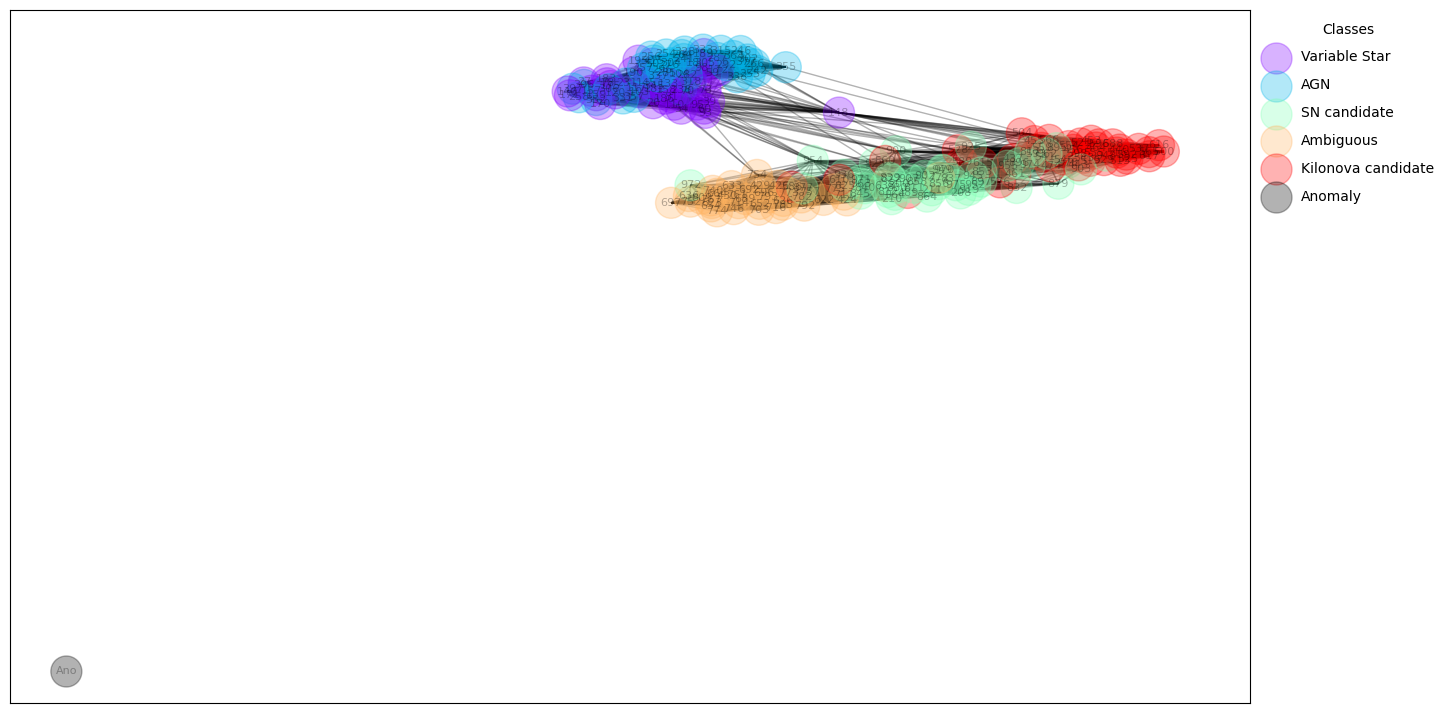

In [26]:
#defining the graph
G = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

#add edges
dict_edges = {}
for i in range(len(df_filt_selected_sample2)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred


#adding anomaly edges
dict_edges[len(df_filt_selected_sample2)] = {}
color_map.append("black")
G.add_node("Ano")
plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")

for j in range(len(df_filt_selected_sample2)):
    pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[0].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))

    if pred > 0.5:
        G.add_edge("Ano", df_filt_selected_sample2.index[j])
        

        dict_edges[i][j] = pred
        dict_edges[j][i] = pred

            

nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

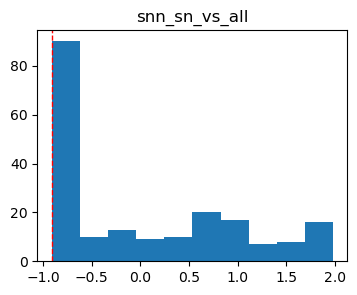

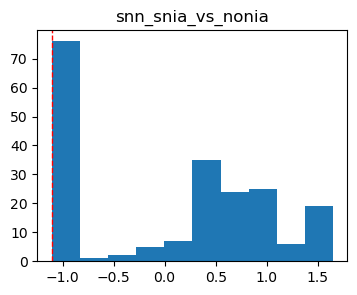

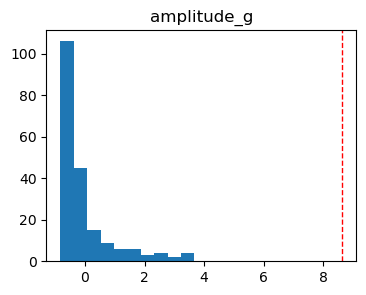

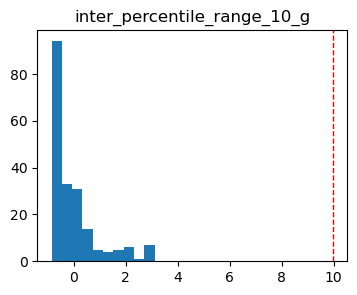

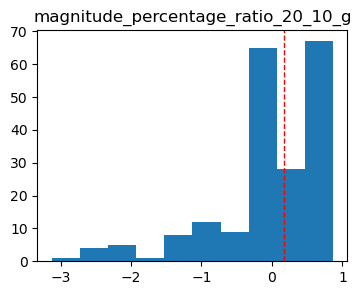

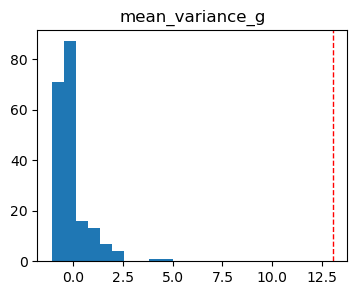

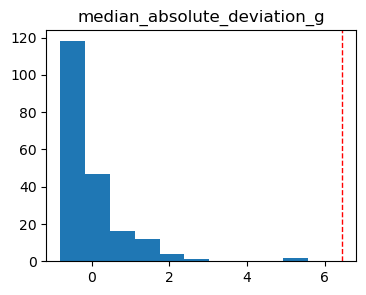

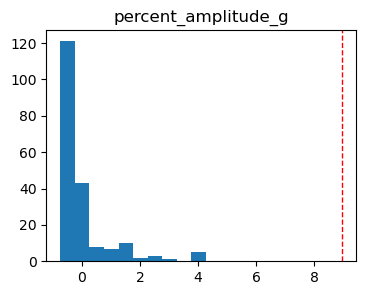

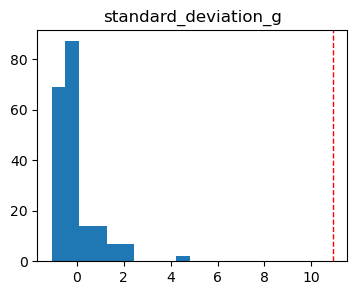

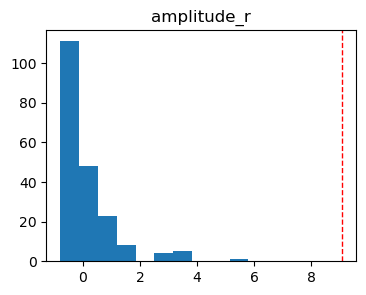

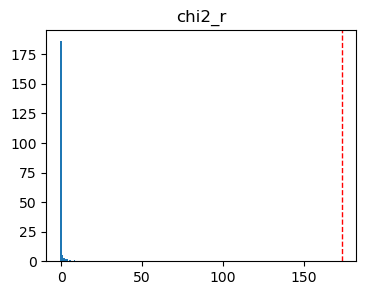

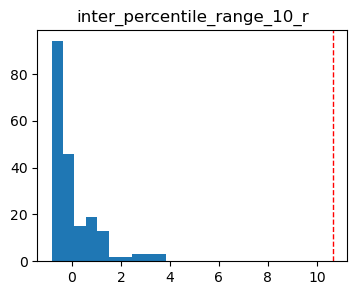

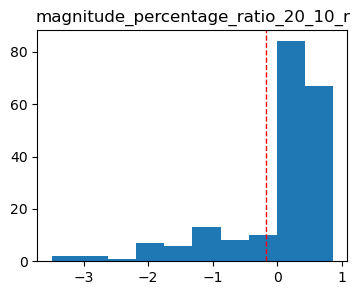

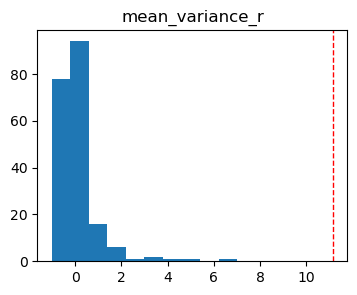

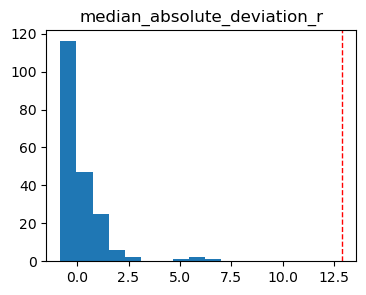

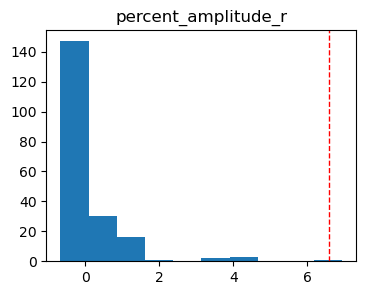

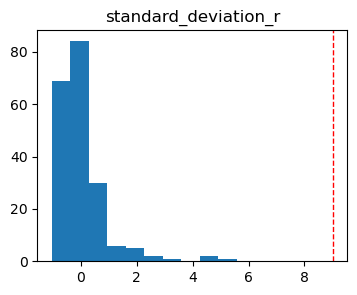

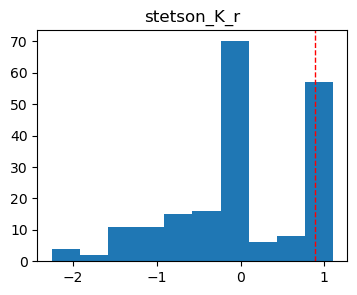

In [27]:
#plot the historogram of every features in df_filt_selected_sample2
for i in range(len(df_filt_selected_sample2.columns)):
    plt.figure(figsize=(4,3))
    plt.hist(df_filt_selected_sample2.iloc[:,i], bins=10)
    #plot the anomaly
    plt.axvline(anomaly_filt_selected.iloc[0][i], color='r', linestyle='dashed', linewidth=1)
    plt.title(df_filt_selected_sample2.columns[i])
    plt.show()

In [28]:
anomaly_filt_selected

,snn_sn_vs_all,snn_snia_vs_nonia,amplitude_g,inter_percentile_range_10_g,magnitude_percentage_ratio_20_10_g,mean_variance_g,median_absolute_deviation_g,percent_amplitude_g,standard_deviation_g,amplitude_r,chi2_r,inter_percentile_range_10_r,magnitude_percentage_ratio_20_10_r,mean_variance_r,median_absolute_deviation_r,percent_amplitude_r,standard_deviation_r,stetson_K_r
0,-0.911023,-1.107845,8.633198,9.984703,0.17847,13.054893,6.447848,8.9553,10.944348,9.078604,173.788057,10.675381,-0.176285,11.178745,12.900002,6.577906,9.039852,0.885997


## Mesure de performance

In [29]:
print(label_sample2.value_counts())

tab_ele = label_sample2.value_counts()
theorical = 0

for key, ind in tab_ele.items():
    theorical += int(ind*(ind-1)/2)

print("Number of link if each alert is connected to all and only all alerts with the same class :", theorical)

SN candidate          47
Kilonova candidate    41
AGN                   38
Variable Star         37
Ambiguous             37
Name: finkclass, dtype: int64
Number of link if each alert is connected to all and only all alerts with the same class : 3936


In [30]:
count = 0

for edge in G.edges():
    if "Ano" not in edge:
        if df['finkclass'][edge[0]] == df['finkclass'][edge[1]]:
            count += 1

print("Number of good link in the graph :", count, "number of link in the graph :", len(G.edges()))
print("Ratio:", count/len(G.edges()))

Number of good link in the graph : 2371 number of link in the graph : 3878
Ratio: 0.611397627643115


# Tune the Graph

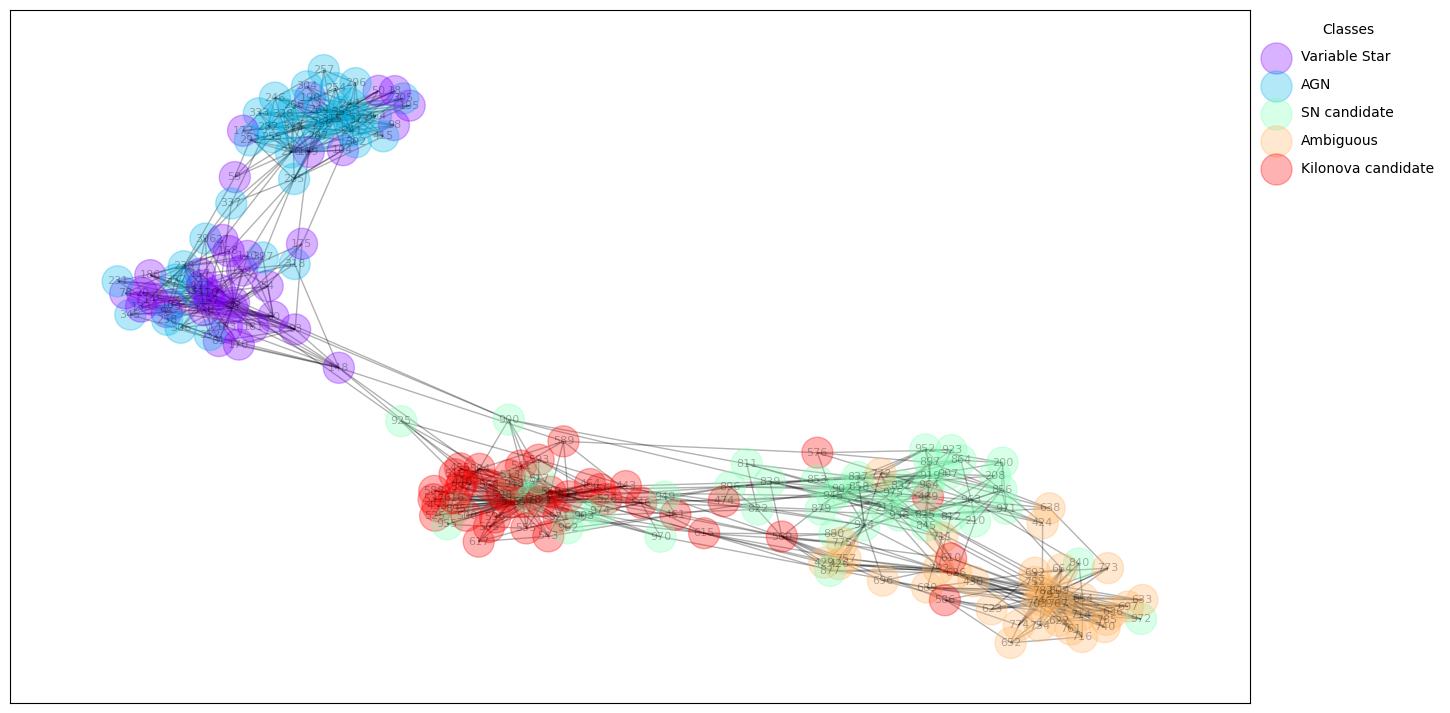

In [31]:
number_max_of_edges = 5

#defining the graph
G = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

#add edges 
for i in range(len(df_filt_selected_sample2)): 
    if len(dict_edges[i]) <= number_max_of_edges:
        for ind, key, in enumerate(dict_edges[i]):
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[key])

    else:
        keys = sorted(dict_edges[i], key=dict_edges[i].get, reverse=True)[:number_max_of_edges]
        for key in keys:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[key])

            

nx.draw_networkx(G, with_labels=True, node_color=color_map, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [32]:
count = 0

for edge in G.edges():
    if "Ano" not in edge:
        if df['finkclass'][edge[0]] == df['finkclass'][edge[1]]:
            count += 1
 
print("Number of good link in the graph :", count, "number of link in the graph :", len(G.edges()))
print("Ratio:", count/len(G.edges()))

Number of good link in the graph : 588 number of link in the graph : 867
Ratio: 0.6782006920415224


In [33]:
#save the model net

folder = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

torch.save(net.state_dict(), 'results/models/model.pt')
np.savetxt('results/models/errors.csv', error, delimiter=',')


# Graph Neural Network

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

# Définition du graphe de train

convert_class = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Ambiguous': 3,
 'Kilonova candidate': 4}

def convert_class_to_int(x):
    return convert_class[x]


x = torch.tensor([df_filt_selected_sample.index], dtype=torch.float)  # Caractéristiques des nœuds
y = torch.tensor([label_sample.apply(convert_class_to_int).to_numpy()], dtype=torch.float)
start = []
end = []
classe = []

for i in range(len(df_filt_selected_sample)):
    for j in range(i + 1, len(df_filt_selected_sample)):
        pred = float(net(torch.tensor([[df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            start.append(i)
            start.append(j)
            end.append(i)
            end.append(j)

edge_index = torch.tensor([start, end], dtype=torch.long)  # Indices d'arête

from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instanciation du modèle
model = GNNClassifier(in_channels=200, hidden_channels=512, out_channels=200)

# Définition de la fonction de perte et de l'optimiseur
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Entraînement du modèle
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

# Prédiction sur de nouvelles données
x = torch.tensor([df_filt_selected_sample2.index], dtype=torch.float)  # Caractéristiques des nœuds
y = torch.tensor([label_sample2.apply(convert_class_to_int).to_numpy()], dtype=torch.float)
start = []
end = []
classe = []

for i in range(len(df_filt_selected_sample2)):
    for j in range(i + 1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            start.append(i)
            start.append(j)
            end.append(i)
            end.append(j)

edge_index = torch.tensor([start, end], dtype=torch.long)



model.eval()
with torch.no_grad():
    new_data = Data(x=torch.tensor([df_filt_selected_sample.index], dtype=torch.float),
                    edge_index=edge_index)
    out = model(new_data)
    predicted_classes = torch.argmax(out, dim=1)
    print(predicted_classes)

/tmp/ipykernel_2338/1156512589.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /croot/pytorch_1675190298929/work/torch/csrc/utils/tensor_new.cpp:201.)
  y = torch.tensor([label_sample.apply(convert_class_to_int).to_numpy()], dtype=torch.float)


tensor([155])


In [70]:
out

tensor([[  481.4625,  1960.9386,  -962.3068,  2906.1426, -8477.8184,  1052.7524,
           433.1138,  1491.6824,  1056.2839,  1874.4457,  1156.9005,   571.7602,
           547.2077,  1125.4286,  -382.6735, -1263.7432,  2339.6448,  2829.8164,
          2390.1848, -1153.2687,  1157.4602,  1526.7775,  1517.1355,   683.0297,
          -274.3651,  1934.2010,  2023.5332,   742.4426,   548.8695,  1780.0167,
           762.5834,   999.1404,   569.0972,  1429.6692,   716.6708,  1894.7874,
          1573.3333,   252.3012,  1251.8092,  1756.5549,  1769.3933,  1228.9149,
           984.6918,  2215.7009,   738.8901,  1608.0228, -1426.4783,  1243.5060,
           572.8425,  1695.1166,   474.1576,  1457.8490,   855.7292,  -435.9915,
          1206.0485,  1294.2516,   718.6974,  1602.6587,  2142.9514,  1372.7369,
          1668.5361,  -393.0234,  1071.2053,  1463.9146,  1381.8804,   809.6849,
          1229.3679,  2555.6575,  1484.8708,   402.5022,   771.1758,  2428.2566,
           796.7025,  2753.2